<a href="https://colab.research.google.com/github/neonkitchen/sift/blob/master/SIFTimplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing packages needed...
from skimage import data
import numpy as np
import cv2 
from skimage.color import rgb2gray
import pylab

In [0]:
# Mounting Gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


---


# Implementation of Scale Invariant Feature Transfrom (SIFT) 

---

## Background

>
>**Scale Invariant Feature Transform (SIFT)**, extracts a set of highly distinctive features, invariant to translation, rotation and scaling. This invariance facilitates matching between images in the presence of afﬁne distortions, 3D viewpoint changes, noise additions and illumination changes. The feature extraction costs are minimized by a cascade filtering approach, with expensive operations only applied if an initial test is passed.
>
>
>### Feature extraction process
>
>The feature extraction process consists of four phases. 
>
>#### *Phase I - Scale-Space extrema detection*
>
>Initially, scale and rotation invariant **candidate interest points** are identified through searching over all scales and image locations. 
>
>#### *Phase II - Keypoint localization*
>
>A detailed model is fit at each candidate interest point to determine location and scale. Measures of stability are then used to filter these candidate interest points, resulting in **keypoints**.
>
>####  *Phase III - Orientation assignment*
>
>**Orientations** are assigned to each keypoint location based on local image gradient directions. All image data is then transformed based on each feature's orientation, scale and location. This results in the aforementioned **invariance**.
>
>####  *Phase IV - Keypoint descriptor*
>
>Local image gradients are measured at each scale in regions surrounding each keypoint. The representation is then transformed, allowing for significant local shape distortion and illumination change.
>
> ### Matching process
>The features are first extracted from a set of reference images and stored in a database. Features extracted from a new image are individually compared to matched to this previously stored database based on the Euclidean distance between the feature vectors. This process is done efficiently with databases using the  **fast nearest-neighbor algorithm**.
>










# Feature extraction process
>## Phase I - Scale-Space extrema detection
>
> Candiate keypoints are deteted using a cascade filtering approach, which minimises computational cost via an efficient algorithm. This phase identifies **locations** and **scales** that can be **repeatably assigned** under 3D viewpoint changes. This is achieved by searching for stable features across all possible scales, using a continuous scale space function with a Gaussian kernel.
> 
>This **Gaussian scale space** is a family of digital images relative to a discrete set of blur levels and diﬀerent sampling rates (image size).  This Gaussian scale space derived from an input image $u_{in}$ with assumed blur level $\sigma_{in}$ . This family is then split into subfamilies of images sharing a common sampling rate. Since the sampling rate is iteratively decreased by a factor of two, these subfamilies are called **octaves**, representing sets of a particular size, increasing in blur. 
>
>Stable keypoint locations in scale space are detectected using scale-space extrema in the **difference-of-Gaussian** (DoG) function convolved with the image. This is efficiently computed via image subtraction of two nearby scales.
>
>It is important to note that this function approximates the scale-normalized Laplacian of Gaussian, which is known to produce stable features at minima and maxima.  When the difference-of-Gaussian function has scales differing by a constant factor, the $\sigma^2$ scale normalization, required for the scale-invariance, is incorporated. This process is shown in *Figure 1* below [1].

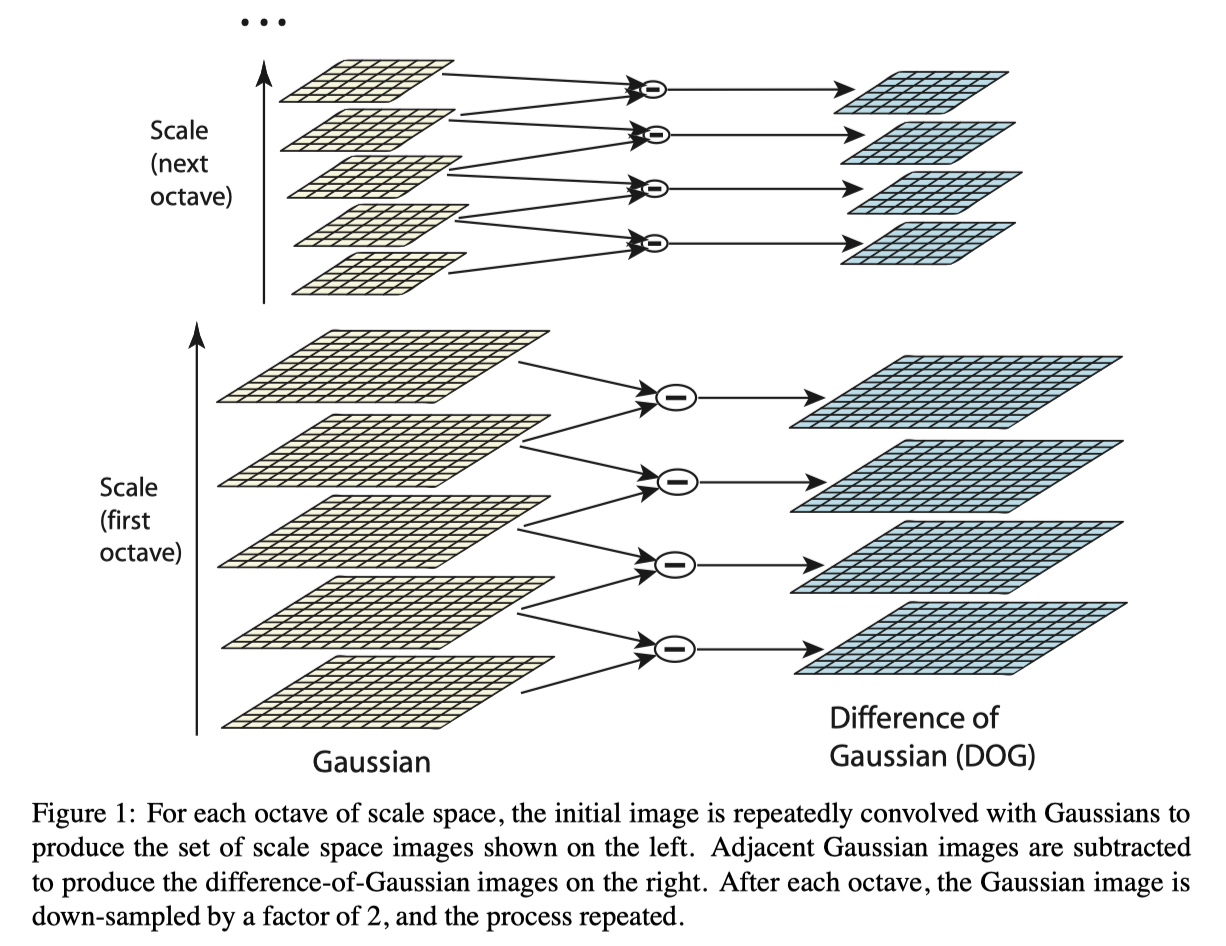

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/DoG_ss.jpg", width =700)

> In order to detect the local extrema, that will become the candidate keypoints, pixels are compared to their "bounding" pixels. These "bounding" pixels are within the same image, as well as in the upper and lower neighbors, with differing blur, in a DoG scale space octave.   This is illustrated in Figure 2 below [1]:

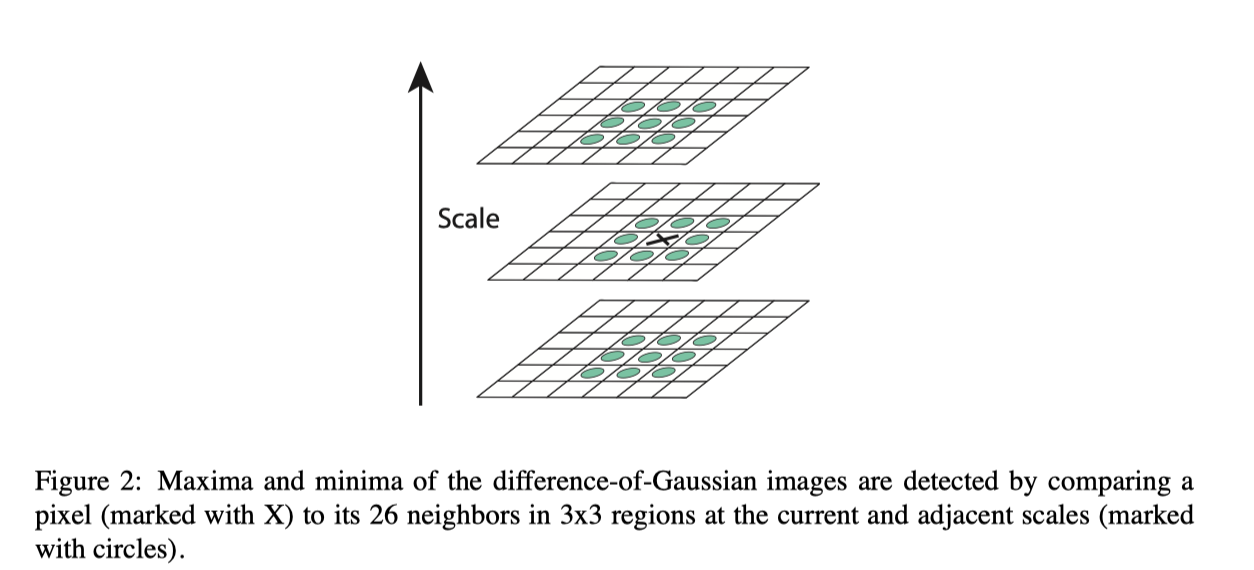

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/extrema.jpg", width =700)

>This phase is implemented via the following methods:
>
>
>*   `compute_ss()`
>*   `compute_DoG_ss()`
>*   `compute_candidate_extrema()`
>
>
> In addition the helper functions `show_ss()` and  `show_extrema` are used to display the resultant scale space and candidate extrema respectively. It is worth noting that in `show_ss()` the size decreases in each octave, even though it is displayed as the same size. This is seen in the reduced pixel dimensions despite being plotted as the same size.
>
> Input image `u` is input into `compute_ss()`, resulting in scale-space `v`. This is then input into `compute_DoG_ss()`, resulting in DoG scale space `w`. Finally this is input into  `compute_candidate_extrema()` resulting in candidate extrema characterized by a list of positions and scale tuples ` L_A` capturing the octave, scale and candidate keypoint location as `[o,s,m,n]`.
>
The candidate keypoints are then examined in further details in the phases that follow.
>
---

>## Phase I - Scale-Space extrema detection - methods
>
>This implementation has been aligned closely with the pseduocode notation, outlined below [2]:

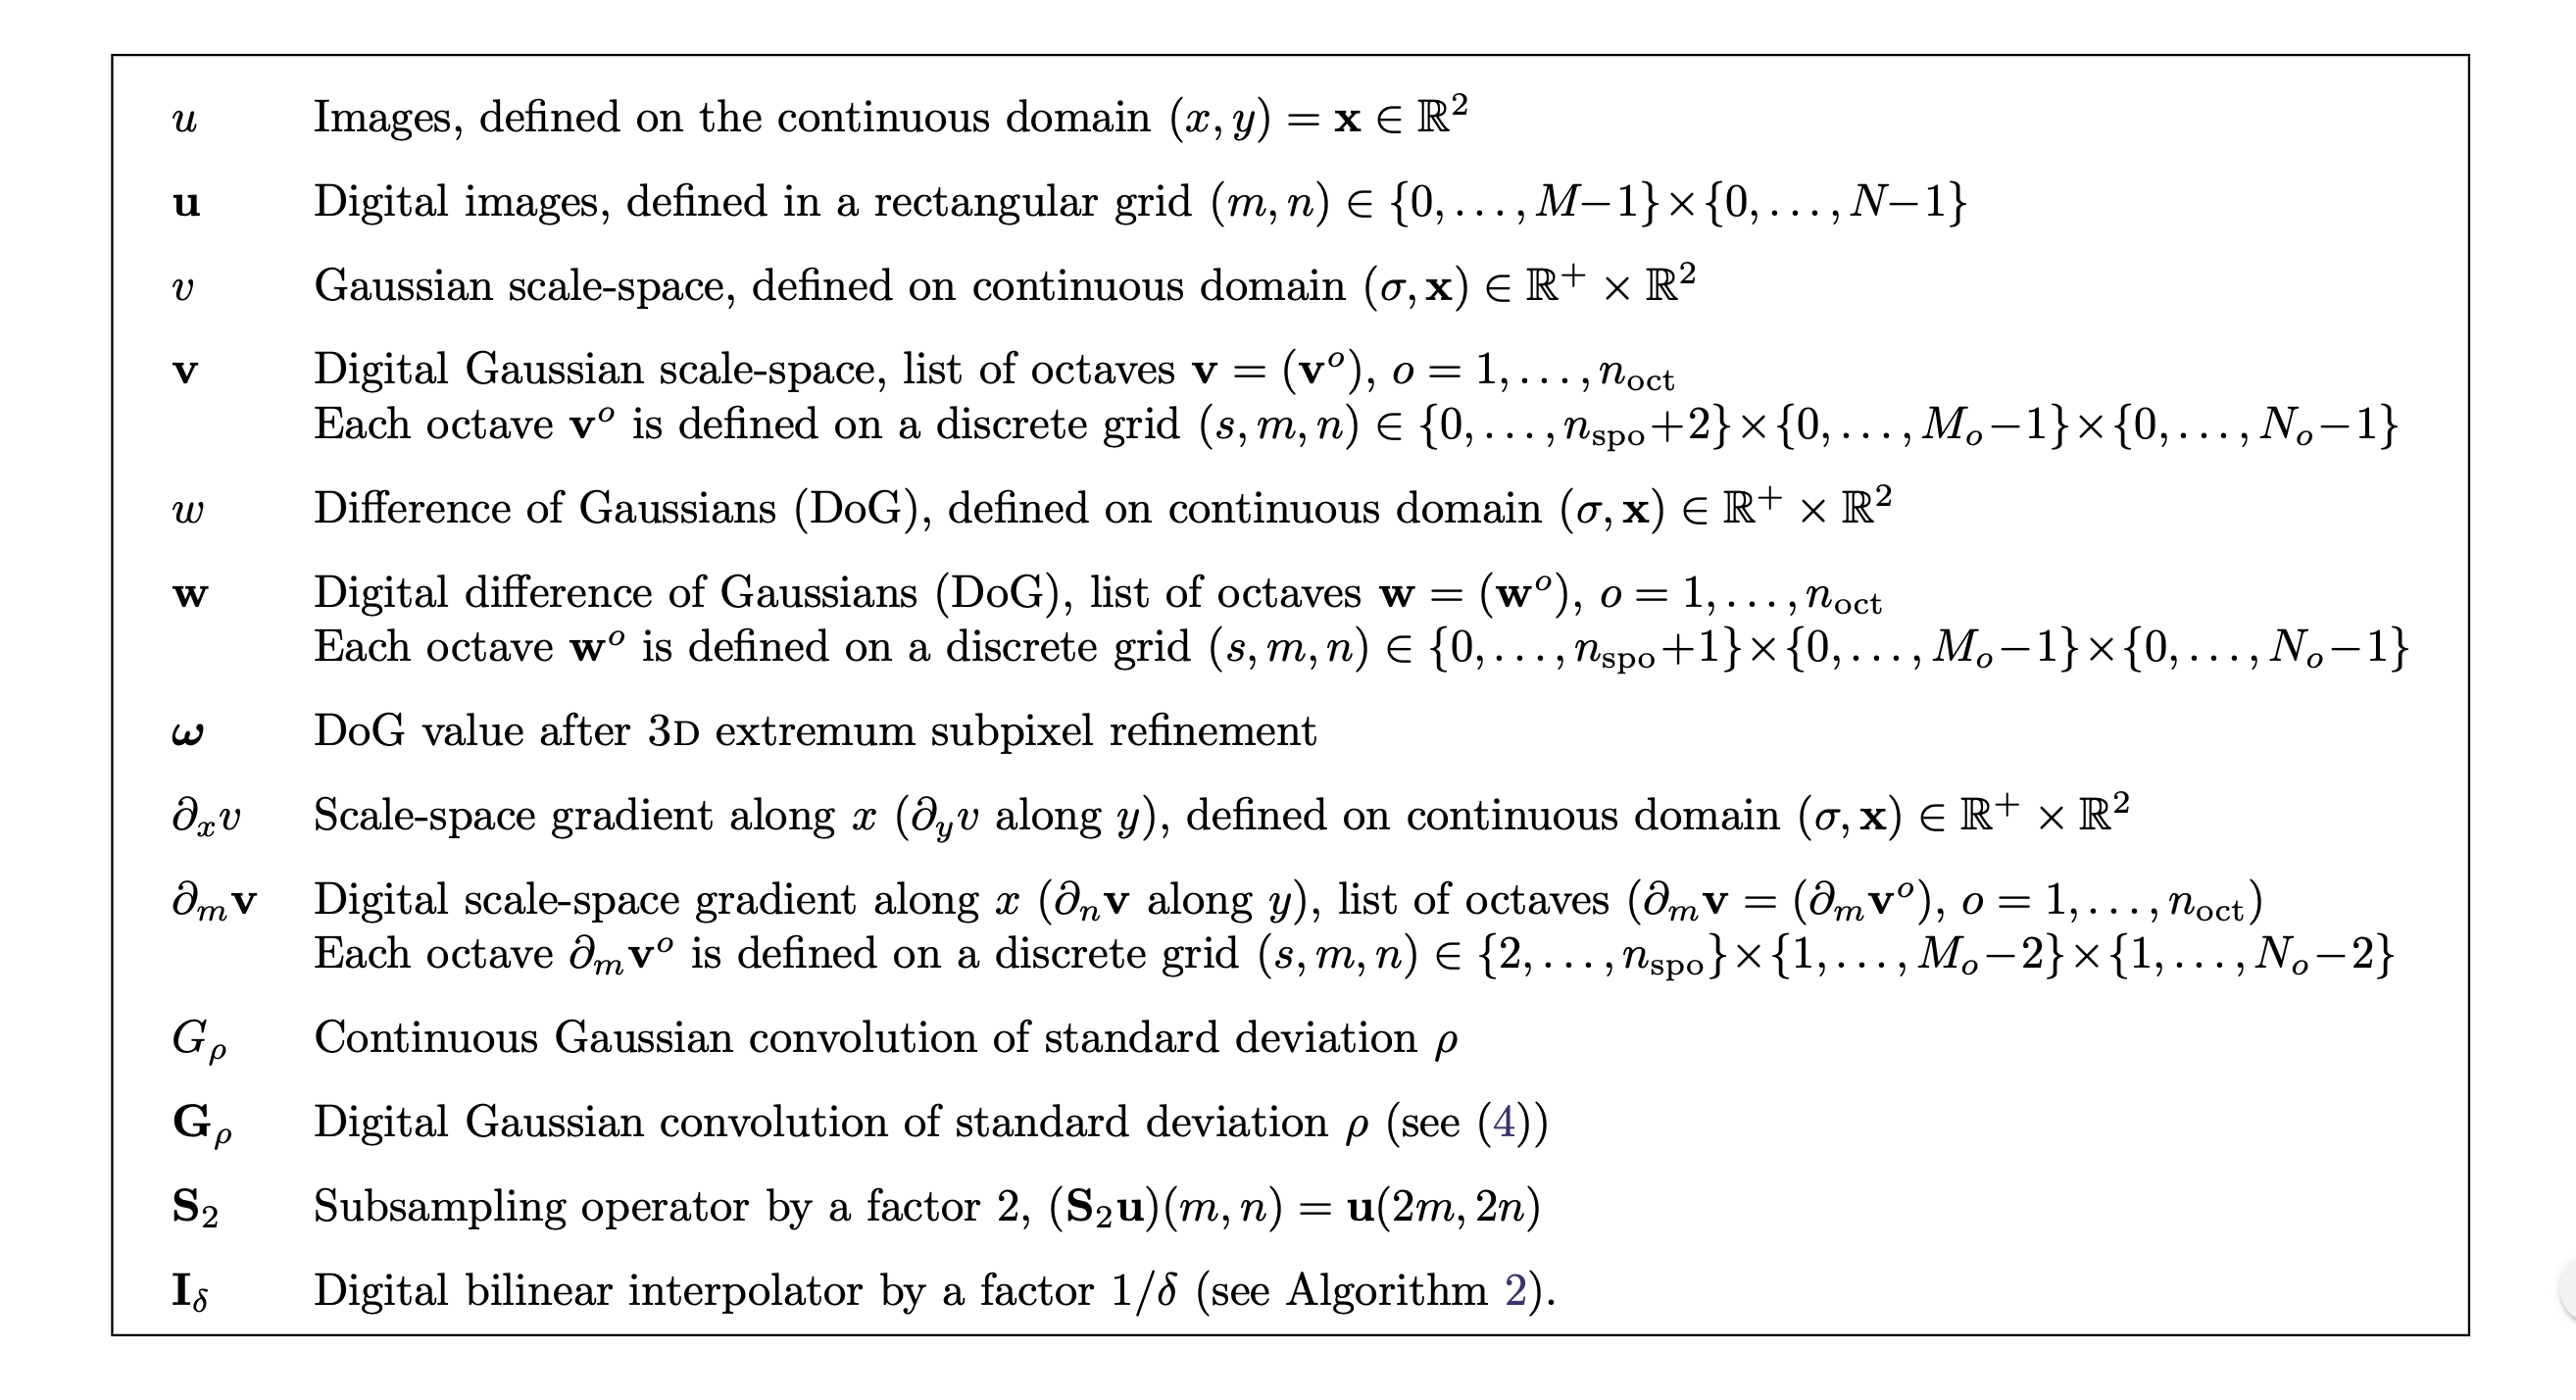

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/notation.jpg", width =800)

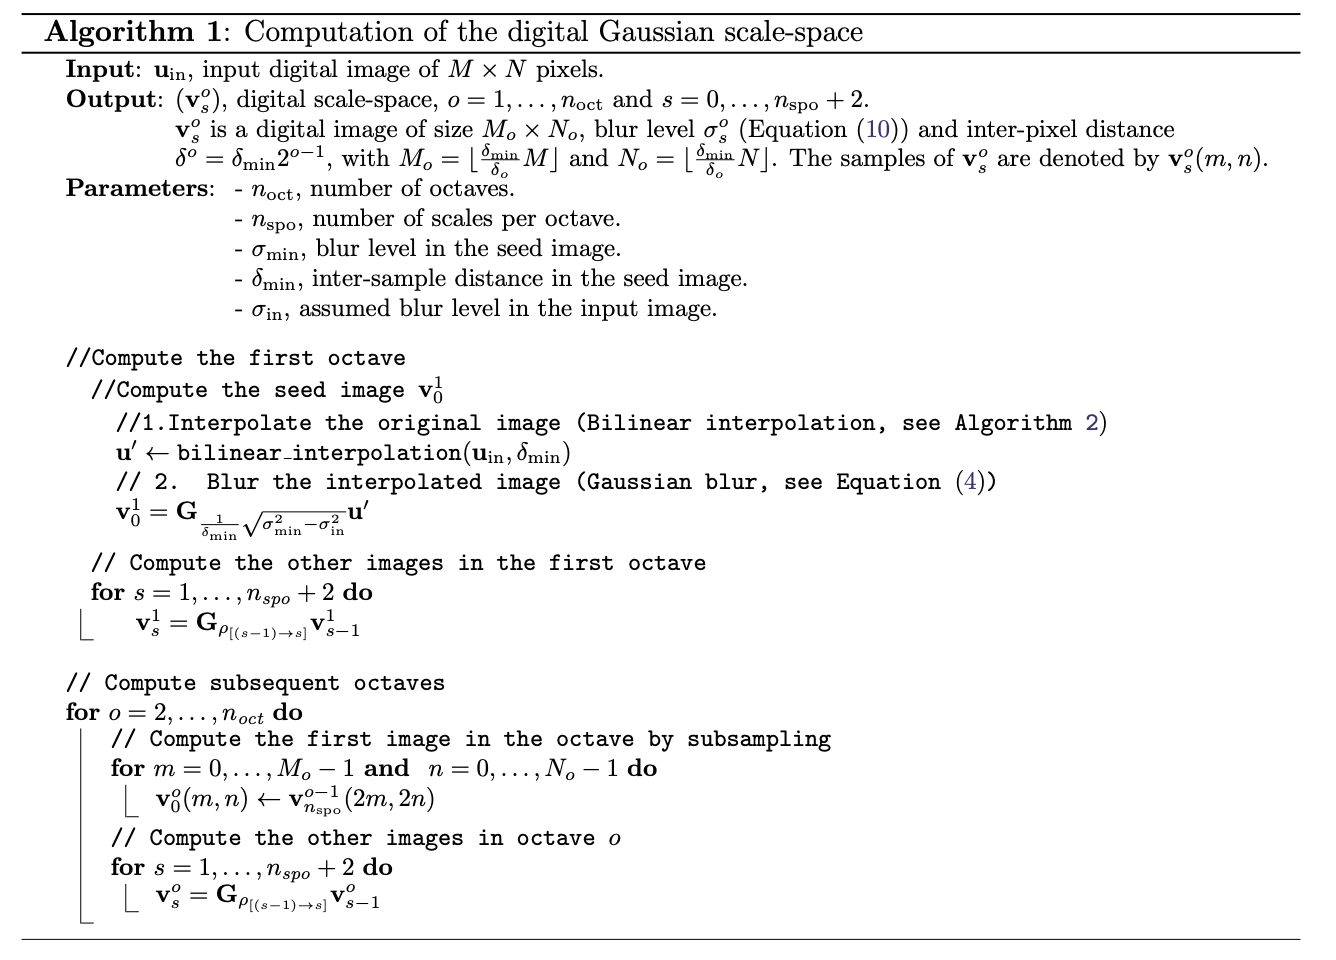

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/algo1.jpg", width =800)

Source: [2]

In [0]:
def compute_ss(u_in,n_oct=4, n_spo=3, d_min=0.5, sigma_min=0.8, sigma_in=0.5):
    
    """
    (~Algo1)
    Creates digital gaussian scale space from input image
    
    Inputs:
    -u_in: input image
    -n_oct: number of octaves (limited by number of subsamples possible)
    -n_spo: number of scales per octave
    -sigma_min: blur level of seed image
    -d_min: inter-sample distance in seed image
    -sigma_in: assumed blur level in input image
    
    Outputs:
    -v: digital gaussian scale space [n_octv ** n_spo] array
        - rows: n_oct octaves 
        - columns: n_spo scales per octave
    
    """

    
    v = np.empty((n_oct,n_spo+3),dtype=object)
    sigma = sigma_min
    k = 2 ** (1 / n_spo)
    
    #COMPUTE FIRST OCTAVE
    
    #Computer seed image v[0,0]
    
    #1. Interpolate orignal image (Bilinear interpolation) <-- NOT IMPLEMENTED 
    #u = bilateral_interpolation(u_in, d_min) 
    u=u_in
    
    #2. Gaussian blur interpolated image
    v[0,0] = cv2.GaussianBlur(u, (0, 0), sigma, sigma)
    
    # Compute other images in first octave
    for s in range(1, n_spo+3):
        #v[0,s] = gaussian_blur(v[1,s-1])
        sigma = k * sigma
        v[0,s]=cv2.GaussianBlur(v[0,s-1], (0, 0), sigma, sigma) 

    #COMPUTE SUBSEQUENT OCTAVES
    
    
    for o in range(1,n_oct):
        
        #Compute first image in octave by subsampling
        v[o,0] = cv2.pyrDown(v[o-1,0])
        
        #compute other images in octave o
        sigma = sigma_min
        for s in range(1, n_spo+3):
            sigma = k * sigma
            v[o,s]=cv2.GaussianBlur(v[o,s-1], (0, 0), sigma, sigma) 
    return v
    

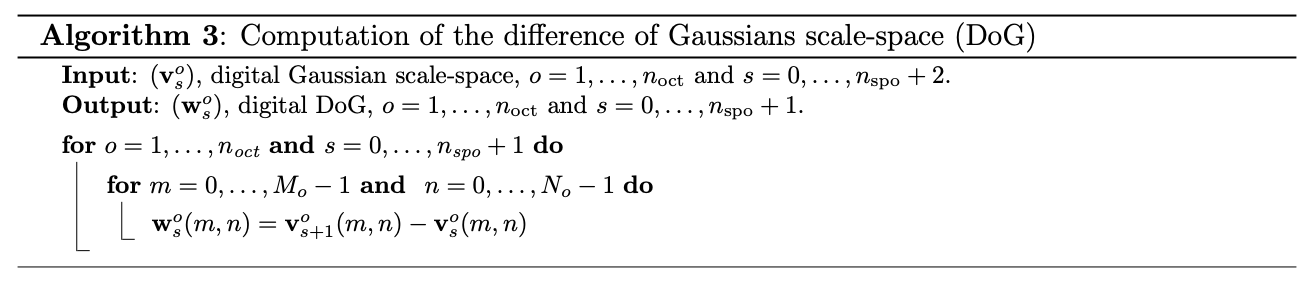

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/algo3.jpg", width =700)

Source: [2]

In [0]:
def compute_DoG_ss(v):
    """
     (~Algo3)
    Creates digital gaussian scale space from input image
    
    Input:
    - v: digital gaussian scale space, as output from compute_ss()
    Output:
    -w: difference of gaussian scale space 
    
    """
    w = np.empty((v.shape[0],v.shape[1]-1),dtype=object)
    for i in range(v.shape[0]):   
        for j in range(v.shape[1]-1):
            w[i,j] = v[i,j+1] - v[i,j]
               
    return w

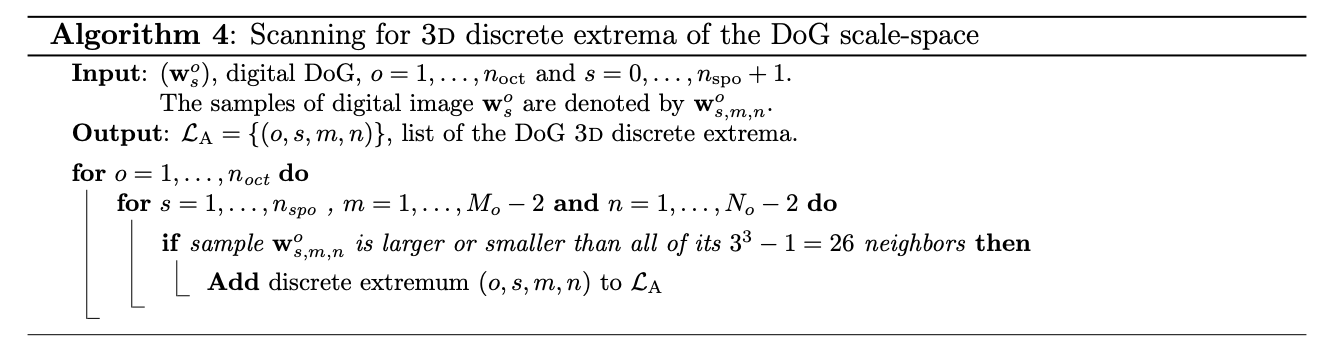

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/algo4.jpg", width =700)

Source: [2]

In [0]:
def compute_candidate_extrema(w, verbose=False):
    """
     (~Algo4)
    Returns list of DoG 3D extrema tuples
    
    Input:
    -w: DoG scale space as output by compute_DoG_ss
    
    Output:
    -L_A: list of extrma tuples [o,s,m,n] 
    
    """
    L_A= []
    for o in range(w.shape[0]):
        if verbose: print("o: ", o)
        for s in range(1,w.shape[1]-1):
            if verbose: print("s: ",s)
            for m in range(1,w[o,s].shape[0]-1):
                for n in range(1,w[o,s].shape[0]-1):
                    
                    candidate = w[o,s][m,n]
                    low = w[o,s-1][m-1:m+2,n-1:n+2]
                    mid = w[o,s][m-1:m+2,n-1:n+2]
                    high = w[o,s+1][m-1:m+2,n-1:n+2]
                    appendmax = False
                    
                    if candidate>np.max(low) and candidate==np.max(mid) and candidate>np.max(high):
                        appendmax = True
                        if verbose:
                            print("CANDIDATE MAX: " , candidate)
                            print("low: ", low)
                            print("mid: ", mid)
                            print("high: ", high)
                            print()
                        L_A.append([o,s,m,n])
                    
                    #check if candidate 3D extrema w[o,s][m,n] is min
                    appendmin = False
                    if candidate<np.min(low) and candidate==np.min(mid) and candidate<np.min(high):
                        appendmin = True
                        if verbose:
                            print("CANDIDATE MIN: " , candidate)
                            print("low: ", low)
                            print("mid: ", mid)
                            print("high: ", high)
                            print()
                       

    return L_A 

In [0]:
%matplotlib inline

from matplotlib import pyplot as plt
#pylab.rcParams['figure.figsize'] = (10.0, 8.0)  #controls figure size in ipynb 
def show_ss(v):
    """
    HELPER FUNCTION
    
    Shows scale space generated
    
    Input:
    Any scale space as genereated by compute_ss OR compute_DoG_ss
    
    """
    for i in range(v.shape[0]):
        print("Octave ",i+1)
        for j in range(v.shape[1]):

            plt.imshow(v[i,j])
            plt.show()

In [0]:
def show_extrema(w, L_A):
    """
    HELPER FUNCTION
    
    Displays candidate extrema on DoG scale space in red
    
    Input:
    -w: DoG scale space as output by compute_DoG_s
    -candidate_extrema: corresponding candidate extrema as output by compute_candidate_extrema(w)
    """
 
    L_Arr=np.array(L_A) #converting tuple list to array
    #L_A_back = tuple(map(tuple, L_Arr)) #converting array to tuple list
    o_s = L_Arr[:,0:2]
    for o_s_unique in np.vstack({tuple(row) for row in o_s}):    
        o=o_s_unique[0]
        s=o_s_unique[1]
        img = w[o,s]
        print("Octave: ",o,", Scale: ",s)
        plt.imshow(img)
        m_extrema =  L_Arr[(L_Arr[:,0] == o)&(L_Arr[:,1] == s)][:,2] # m in octave o, scale s
        n_extrema =  L_Arr[(L_Arr[:,0] == o)&(L_Arr[:,1] == s)][:,3] # n in octave o, scale s
        plt.scatter(x=m_extrema, y=n_extrema , c='r', s=1)
        plt.show()

>## Phase I - Scale-Space extrema detection - results

In [0]:
#using impage skimage's data, converting to grayscale & clipping:
img =rgb2gray(data.astronaut()).clip(max=1) #clipping to range[0,1]


In [0]:
scale_space=compute_ss(u_in = img,sigma_min=1.6)

In [0]:
DoG_scale_space = compute_DoG_ss(scale_space)

In [0]:
%matplotlib inline

from matplotlib import pyplot as plt
#pylab.rcParams['figure.figsize'] = (10.0, 8.0)  #controls figure size in ipynb 
def show_ss_TEST(v):
    """
    HELPER FUNCTION
    
    Shows scale space generated
    
    Input:
    Any scale space as genereated by compute_ss OR compute_DoG_ss
    
    """
    fig, axs = plt.subplots(v.shape[0], v.shape[1])
    for i in range(1,v.shape[0]):
      for j in range(1,v.shape[1]):    
            img = v[0,0]
            fig.add_subplot(v.shape[0], v.shape[1], i)
            plt.imshow(img)
    plt.show()

Octave  1


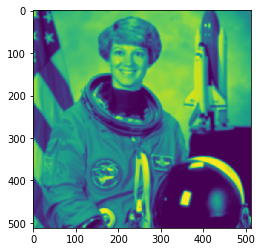

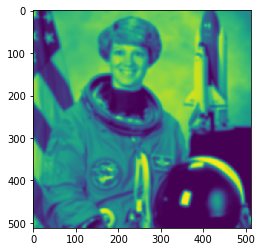

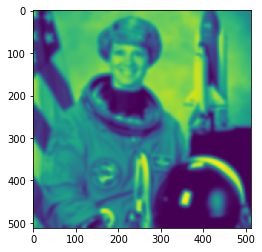

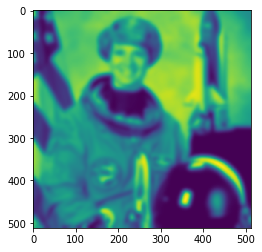

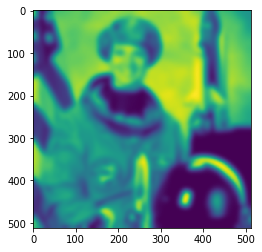

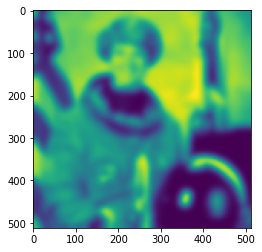

Octave  2


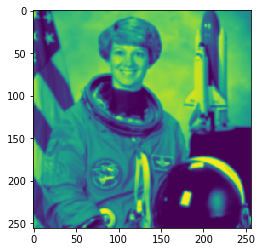

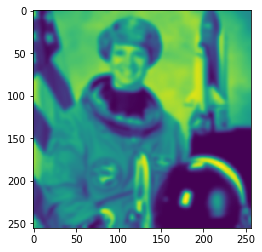

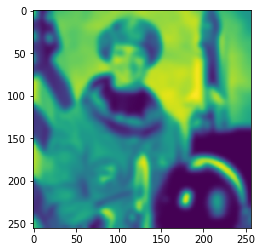

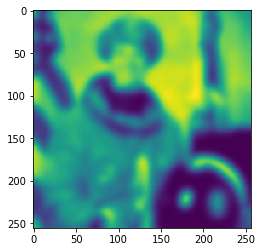

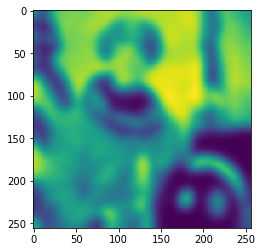

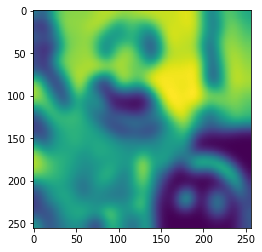

Octave  3


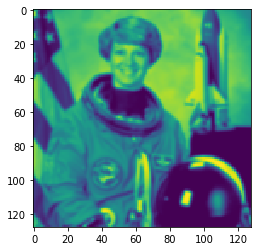

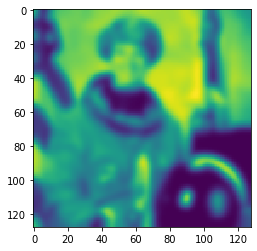

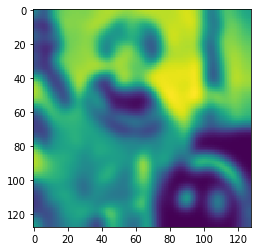

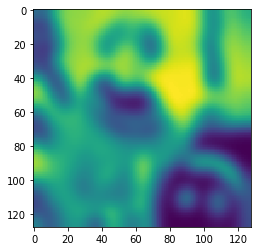

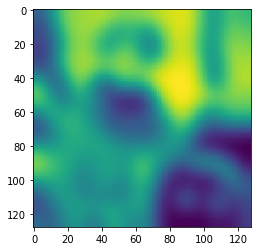

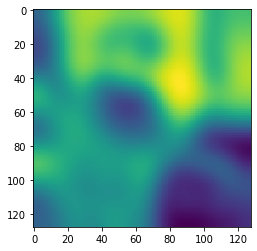

Octave  4


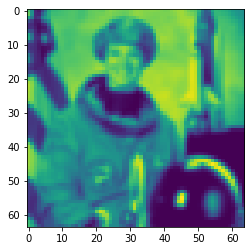

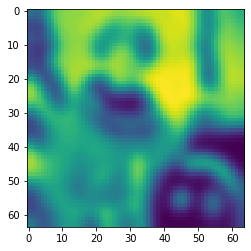

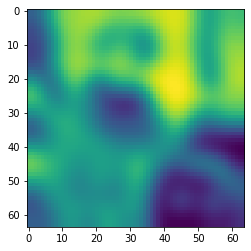

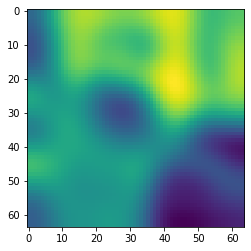

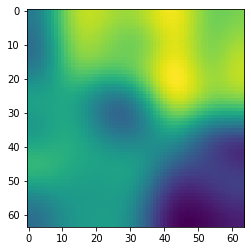

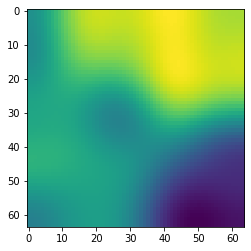

In [0]:
show_ss(scale_space)

Octave  1


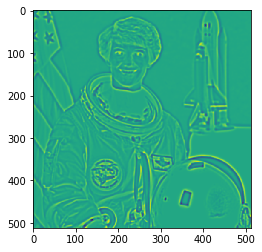

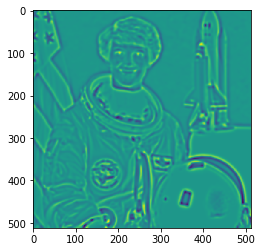

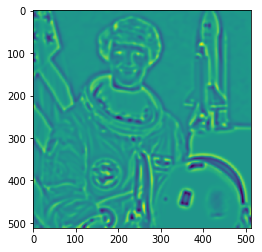

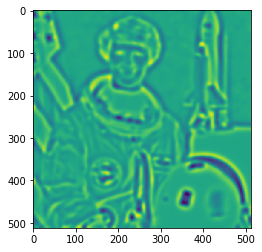

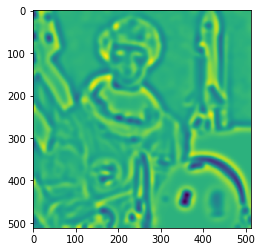

Octave  2


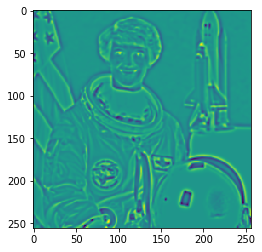

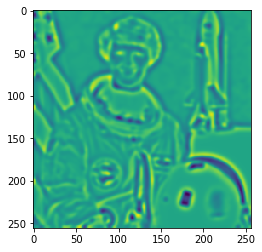

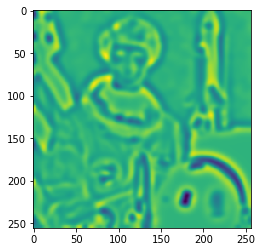

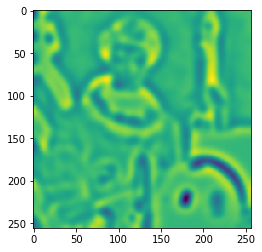

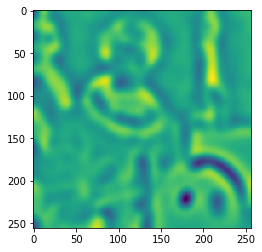

Octave  3


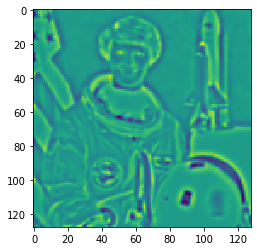

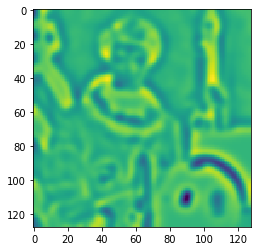

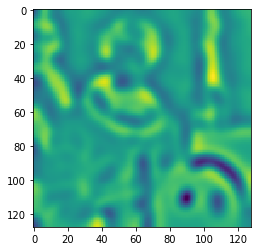

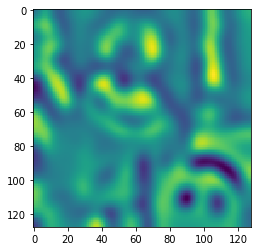

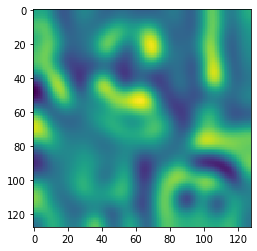

Octave  4


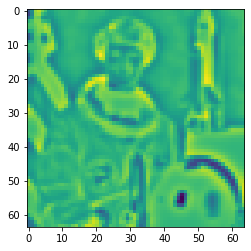

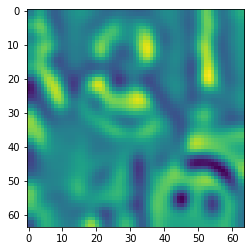

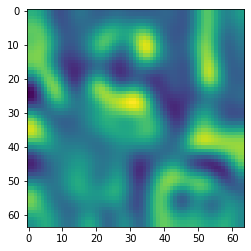

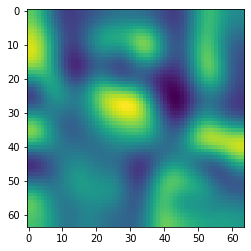

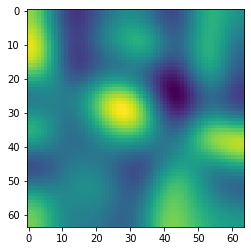

In [0]:
show_ss(DoG_scale_space)

In [0]:
candidate_extrema_list = compute_candidate_extrema(DoG_scale_space, verbose=False)
print("candidate_extrema_list length", len(candidate_extrema_list))

candidate_extrema_list length 120


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


Octave:  0 , Scale:  1


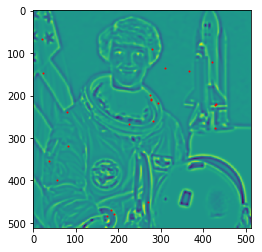

Octave:  1 , Scale:  2


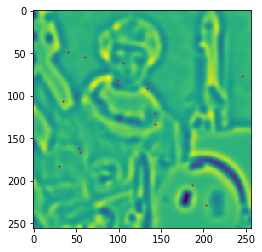

Octave:  1 , Scale:  3


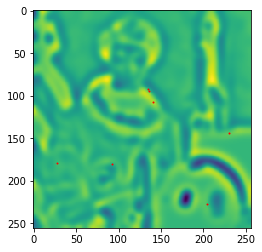

Octave:  0 , Scale:  2


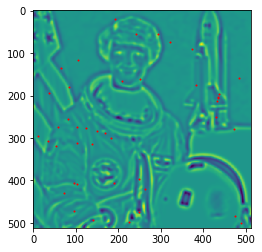

Octave:  2 , Scale:  3


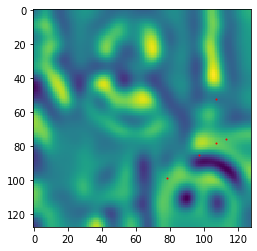

Octave:  2 , Scale:  2


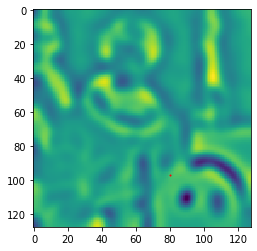

Octave:  0 , Scale:  3


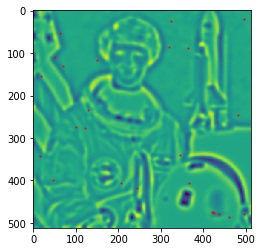

Octave:  1 , Scale:  1


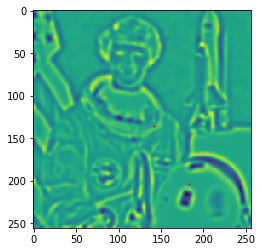

In [0]:
show_extrema(DoG_scale_space, candidate_extrema_list)

> The above implementation of phase 1 shows how `compute_ss()` creates a Guassian scale space from the input image. This consists of 4 octaves of differing size. Each octave has 6 increasingly blurred images.
>
> The DoG scale space is then obtained by running `compute_DoG_ss()`. DoG results in strong response along edges, as seen by the outline of the woman as well as the rocket and flat in the background. It seems that this is because an image with less blur is subtracted from an image with greater blur. Edges, and other traits of interest, are more sensitive to blurring and, as such, their "excess" blur is seen in the DoG scale space. 
>
>Finally, 120 candidate extreme are calculated by `compute_candidate_extrema()`. These are seen in red and seem to focus on edges as well as protruding aspects of object, particularly noticeable on the helmet and space suit. 


# Feature extraction process continued.. 
>## Phase II - Keypoint localization
>
>A detailed ﬁt to nearby data, producing location, scale, and ratio of principal curvatures, is performed on phase I's candidate keypoints.
>
>Low contrast points are sensitive to noise. After discarding these low contrast key points, a 3D quadratic function is fitted to the local candidate keypoints. This uses the quadratic Taylor expansion centred at the candidate keypoint. In this method, the Hessain and derivative are estimated using differences of neighboring sample points, resulting in a linear system that is computationally cheap to solve. This is used to determine the interpolated location of the maximum, resulting in "subpixel" accuracy and improved matching and stability. 
>
>DoG results in strong response along edges, even if the location along the edge is poorly determined. A poorly deﬁned DoG peak has a large principal curvature across the edge and a 
>
>This principal curvature is calculated by a 2x2 Hessain matrix at a keypoints location and scale. The eigen values ratio of this Hessian is computationally inexpensive and is thus used to discarded further keypoints are not extrema.  The resultant pruned keypoints have improved stability and poorly localized keypoints along edges are rejected.
>
>This phase is implemented via the following methods which act as successive filters, pruning the initial set of candidate keypoints:
>
>*   `conservative_test()`
>*   `quadratic_DoG_interpolation()`
>*   `keypoint_interpolation()`
>*   `discard_low_contrast_keypoints()`
>*   `discard_edge_keypoints()`

>## Phase II - Keypoint localization - methods

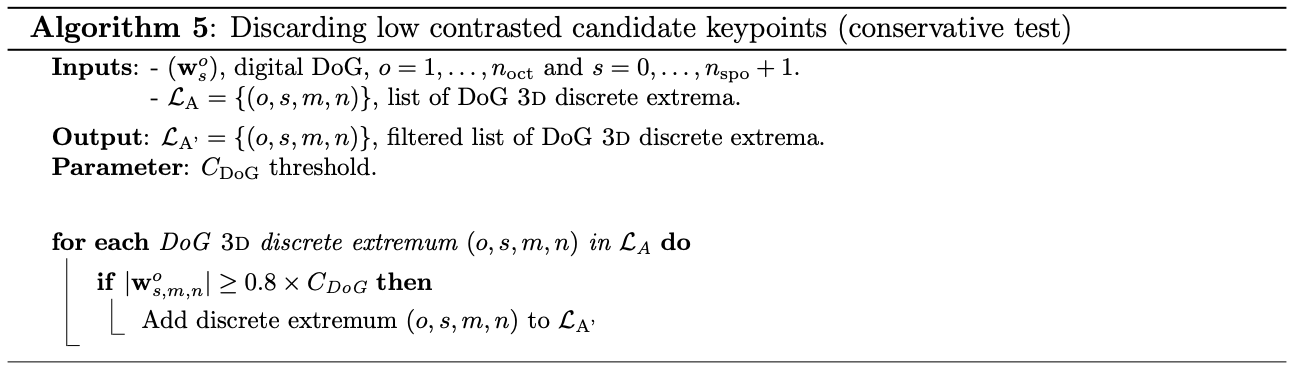

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/algo5.jpg", width =700)

Source: [2]

In [0]:
def conservative_test(w, L_A, C_DoG=0.015):    
    """
    (~Algo5)
    Before  extrema reﬁnement a less conservative threshold 0.8*C_DoG applied
    
    Input:
    -w: DoG scale space as output by compute_DoG_ss()
    -L_A: list of extrema tuples [o,s,m,n] as output by compute_candidate_extrema()
    -C_DoG: threshold, depends on n_spo (guarantees independence from sampling conﬁguration) 
          : C=DoG =0.015 when n_spo =3
    
    Output:
    -L_A_prime: list of filted extrema tuples [o,s,m,n]
    
    """
    L_A_prime = []
    for i in range(len(L_A)):
        o = L_A[i][0]
        s = L_A[i][1]
        m = L_A[i][-2]
        n = L_A[i][-1]
        if np.abs(w[o,s][m][n])>=0.8*C_DoG:
            L_A_prime.append(L_A[i])
            
    return L_A_prime 


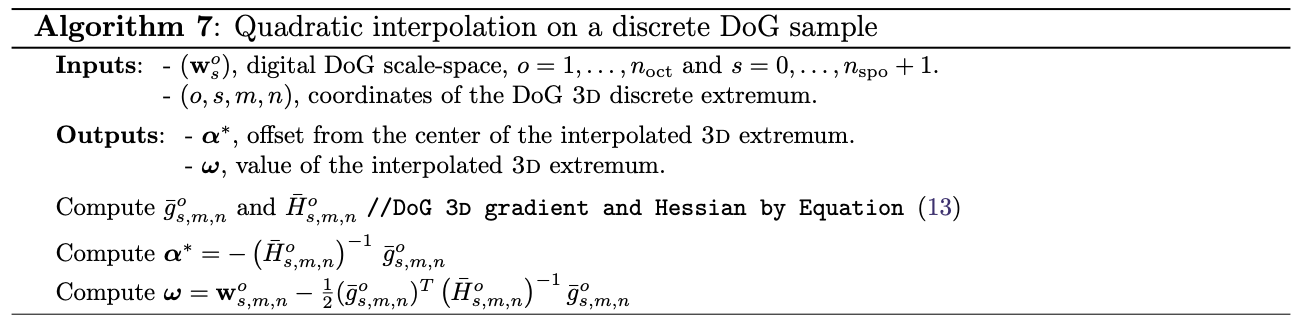

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/algo7.jpg", width =700)

Source: [2]

In [0]:
import numpy.linalg as LA
def quadratic_DoG_interpolation(w, L_A_prime_row):
    """
    (~Algo7)
    Returns list of DoG 3D extrema tuples
    
    Input:
    -w: DoG scale space array as output by compute_DoG_ss()
    -L_A_prime_row: row from filtered list of high contrast extrema tuples [o,s,m,n] 
                  :row i of output of conservative_test()[i] for some i
    
    Output:
    -alpha: offset from centre of interpolated extremum
    -W_row: difference of gaussian scale space row entry after subpixel refinement
    
    """
    o = L_A_prime_row[0]
    s = L_A_prime_row[1]
    m = L_A_prime_row[-2]
    n = L_A_prime_row[-1]
     
    #3D gradient (Jacobian)
    j1 = (w[o,s][m][n]-w[o,s-1][m][n])/2.
    j2 = (w[o,s][m+1][n]-w[o,s][m-1][n])/2.
    j3 = (w[o,s][m][n+1]-w[o,s][m][n-1])/2.
    
    
    #Hessian diagonal
    h11 = w[o,s+1][m][n] + w[o,s-1][m][n] -2*w[o,s][m][n]
    h22 = w[o,s][m+1][n] + w[o,s][m-1][n] -2*w[o,s][m][n]
    h33 = w[o,s][m][n+1] + w[o,s][m][n-1] -2*w[o,s][m][n]
    
    #Hessian off-diagonal
    h12 = (w[o,s+1][m+1][n]-w[o,s+1][m-1][n] - w[o,s-1][m+1][n]+w[o,s-1][m-1][n])/4.
    h13 = (w[o,s+1][m][n+1]-w[o,s+1][m][n-1] - w[o,s-1][m][n+1]+w[o,s-1][m][n-1])/4.
    h23 = (w[o,s][m+1][n+1]-w[o,s][m+1][n-1] - w[o,s][m-1][n+1]+w[o,s][m-1][n-1])/4.
    
    

    J = np.array([j1, j2, j3])
    
    H = np.array([
        [h11, h12, h13],
        [h12, h22, h23],
        [h13, h23, h33]])
    
    alpha_row = -LA.inv(H).dot(J)
    W_row = w[o,s][m][n] - 0.5*J.dot(LA.inv(H).dot(J))
    
    # J & 2D Hessian returned as they are needed in Algo
    return alpha_row, W_row, J, H[:2,:2]


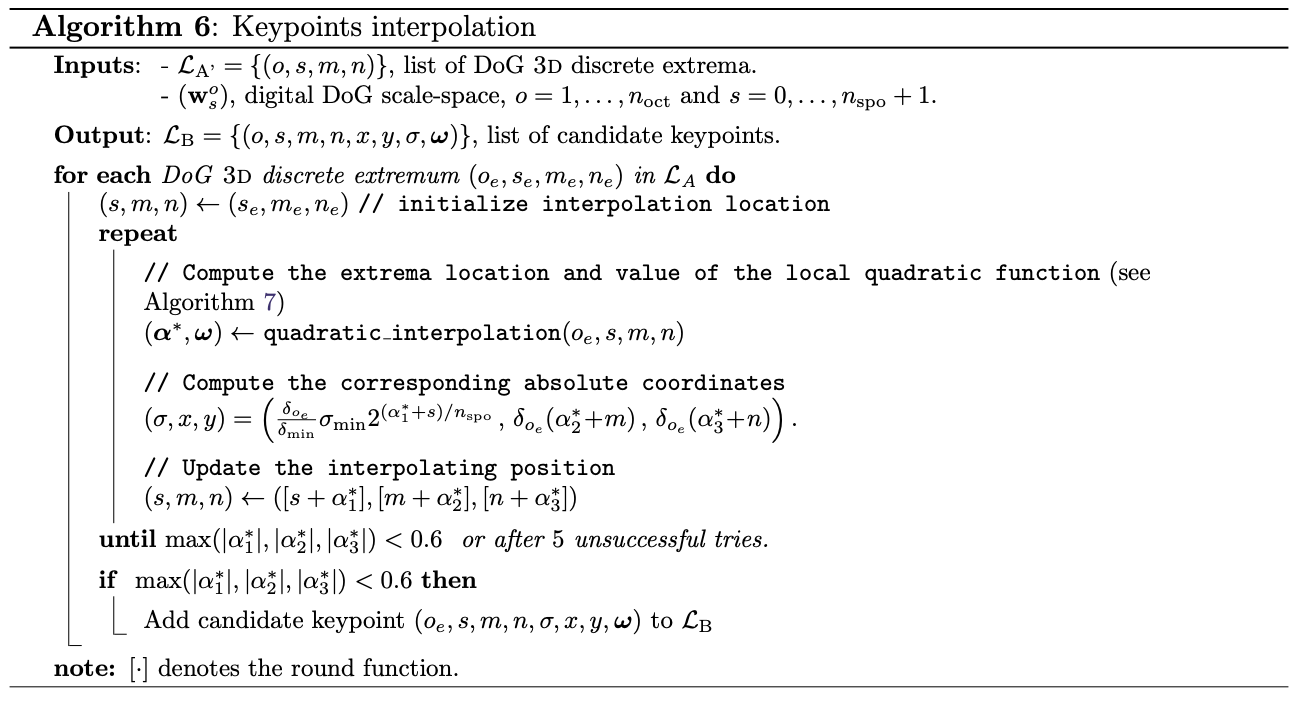

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/algo6.jpg", width =700)

Source: [2]

In [0]:
import numpy.linalg as LA
def keypoint_interpolation(L_A_prime, w, n_spo=3, d_o_e=2, d_min=0.5, sigma_min=0.8):
    """
    (~Algo6)
    Returns list of DoG 3D extrema tuples
    
    Input:
    -L_A_prime: filted list of high contrast extrema tuples [o,s,m,n] as output by conservative_test()
    -w: DoG scale space as output by compute_DoG_ss()
    
    Output:
    -L_B: filted list of sub-pixel refined extrema tuples [o,s,m,n,x,y,sigma,W]
    
    """
    L_B = []
    
    for i in range(len(L_A_prime)):
        o_e = L_A_prime[i][0]
        s_e = L_A_prime[i][1]
        m_e = L_A_prime[i][-2]
        n_e = L_A_prime[i][-1]
        
        #initialise interpolation location        
        s = s_e
        m = m_e
        n = n_e
        
        alpha_row= [0,0,0]
        num_itt=0
        
        while np.max(np.abs(alpha_row))< 0.6 and num_itt<=5:
            
            #compute extrema location & value of local quadratic function
            alpha_idx, W_idx, J, H = quadratic_DoG_interpolation(w, L_A_prime[i])
            
            #compute corresponding absoklute coordinates
            sigma = np.round((d_o_e/d_min)*sigma_min*2**((alpha_row[0]+s)/n_spo))
            x = d_o_e*(alpha_row[1]+m)
            y = d_o_e*(alpha_row[1]+n)
            
            #update interpolating position
            s = np.round(s + alpha_row[0])
            m = np.round(m+ alpha_row[1])
            n = np.round(n + alpha_row[2])                     
            
            L_B.append([o_e, s, x, y,m, n, sigma, W_idx])
            num_itt += 1
            
    return L_B

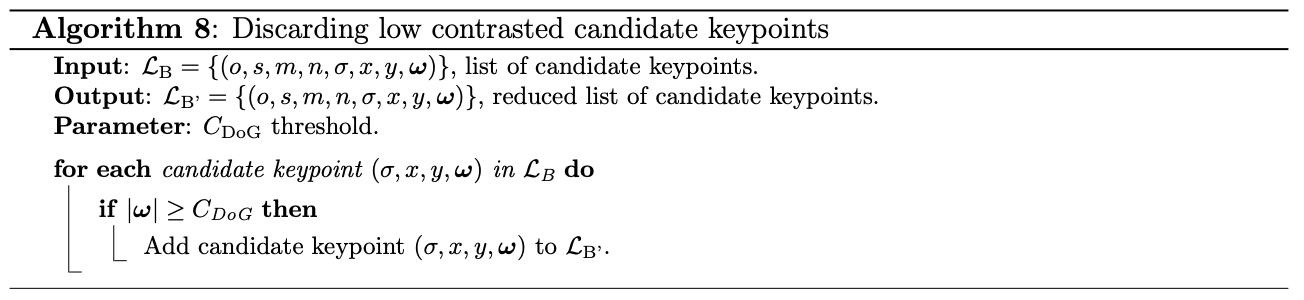

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/algo8.jpg", width =700)

Source: [2]

In [0]:
def discard_low_contrast_keypoints(L_B, C_DoG=0.015):    
    """
    (~Algo8)
    Extrema reﬁnement less conservative threshold C_DoG applied
    
    Input:
    -w: DoG scale space as output by compute_DoG_ss()
    -L_B: list of extrema tuples [o,s,m,n,sigma,x,y,W] as output by keypoint_interpolation()
    -C_DoG: threshold, depends on n_spo (guarantees independence from sampling conﬁguration) 
          : C=DoG =0.015 when n_spo =3
    
    Output:
    -L_B_prime: list of filted extrema tuples [o,s,m,n,sigma,x,y,W]
    
    """
    L_B_prime = []
    for i in range(len(L_B)):
        
        [o, s, m, n, sigma, x, y, W] =L_B[i]
        
        if np.abs(W)>=C_DoG:
            L_B_prime.append([o, s, m, n, sigma, x, y, W])
            
    return L_B_prime 

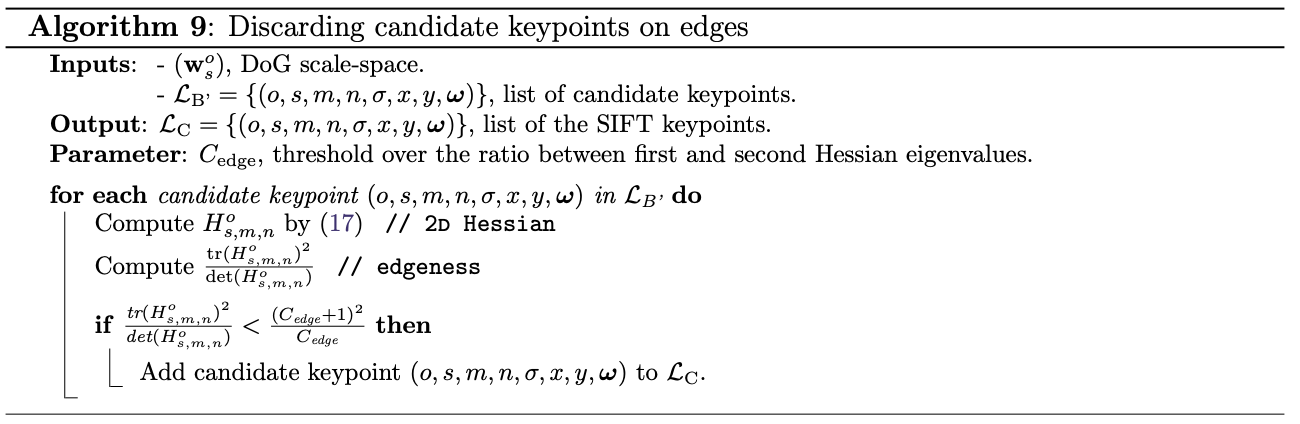

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/algo9.jpg", width =700)

Source: [2]

In [0]:
def discard_edge_keypoints(w,L_B_prime,H,C_edge=0.015):
    """
    (~Algo9)
    
    Input:
    -w: DoG scale space as output by compute_DoG_ss()
    -L_B_prime: list of filted extrema tuples [o,s,m,n,sigma,x,y,W] as output by discard_low_contrast_keypoints()
    -H: 2d Hessian as ouput from quadratic_DoG_interpolation()[3]
    
    Output:
    -L_C: list SIFT keypoints tuples [o,s,m,n,sigma,x,y,W]
    
    Paramaters:
    C_edge: threshold over ratio Hessian's eigenvalues
    
    """
    L_C=[]
    
    for i in range(len(L_B_prime)):
        [o, s, m, n, sigma, x, y, W] =L_B_prime[i]
            
        # compute 2D Hessian from quadratic_DoG_interpolation
        #alpha_row, W_row, J, H = quadratic_DoG_interpolation(w, L_B_prime[i])
        
        #compute edgeness
        H_det = np.linalg.det(H)
        H_trace = np.matrix.trace(H) 
        edgeness = H_trace**2/H_det
      
        
        #threshold edgeness
        if edgeness < (C_edge+1)**2/C_edge:
            L_C.append(L_B_prime[i])
            
    return L_C

>## Phase II - Keypoint localization - results

In [0]:
print("candidate_extrema_list length", len(candidate_extrema_list))
print()
print("discarding low contrast keypoints (conservative test)...")
candidate_extrema_list_f1 = conservative_test(DoG_scale_space, candidate_extrema_list)
print("candidate_extrema_list_f1 length", len(candidate_extrema_list_f1))
print()
print("sub-pixel refinement (keypoint interpolation)...")
print()
candidate_extrema_list_f1_int = keypoint_interpolation(candidate_extrema_list_f1, DoG_scale_space)
print("candidate_extrema_list_f1_int length", len(candidate_extrema_list_f1_int))
print()
print("discarding low contrast keypoints...")
candidate_extrema_list_f2_int = discard_low_contrast_keypoints(candidate_extrema_list_f1_int)
print()
print("discarding edge points...")
print("candidate_extrema_list_f2_int length", len(candidate_extrema_list_f2_int))
print()
SIFT_keypoints = discard_edge_keypoints(DoG_scale_space,candidate_extrema_list_f2_int, quadratic_DoG_interpolation(DoG_scale_space,candidate_extrema_list_f1[0])[3])

candidate_extrema_list length 120

discarding low contrast keypoints (conservative test)...
candidate_extrema_list_f1 length 84

sub-pixel refinement (keypoint interpolation)...

candidate_extrema_list_f1_int length 504

discarding low contrast keypoints...

discarding edge points...
candidate_extrema_list_f2_int length 504



There seems to be an issue with the prunning process at *sub-pixel refinement (keypoint interpolation)* as seen by the increase in keypoints. This was not investigated and *candidate_extrema_list_f1* was used going forward.


# Feature extraction process continued.. 
>## Phase III - Orientation assignment
>
>Local image properties are used to assign an orientation to each keypoint. The keypoint descriptor is thus represented relative to this orientation, achieving invariance to image rotation. 
>
>An orientation histogram is formed from the gradient orientations of sample points around the keypoint. The orientation histogram consist of 36 bins covering the 360 degree range of orientations.
>
>Dominant directions of local gradients correspond to peaks in the orientation histogram. The highest peak in the histogram is detected.  Any other local peak within 80% of the highest peak is used create additional keypoints with that orientation, resulting in multiple keypoints created at the same location and scale but different orientations. These contribute signiﬁcantly to the stability of matching. Finally, a parabola is ﬁt to the 3 histogram values closest to each peak to interpolate the peak position for better accuracy.

Figure 7 below shows how many gradients of different orientation and magnitude may be assigned to each keypoint. 


>## Phase III - Orientation assignment - methods

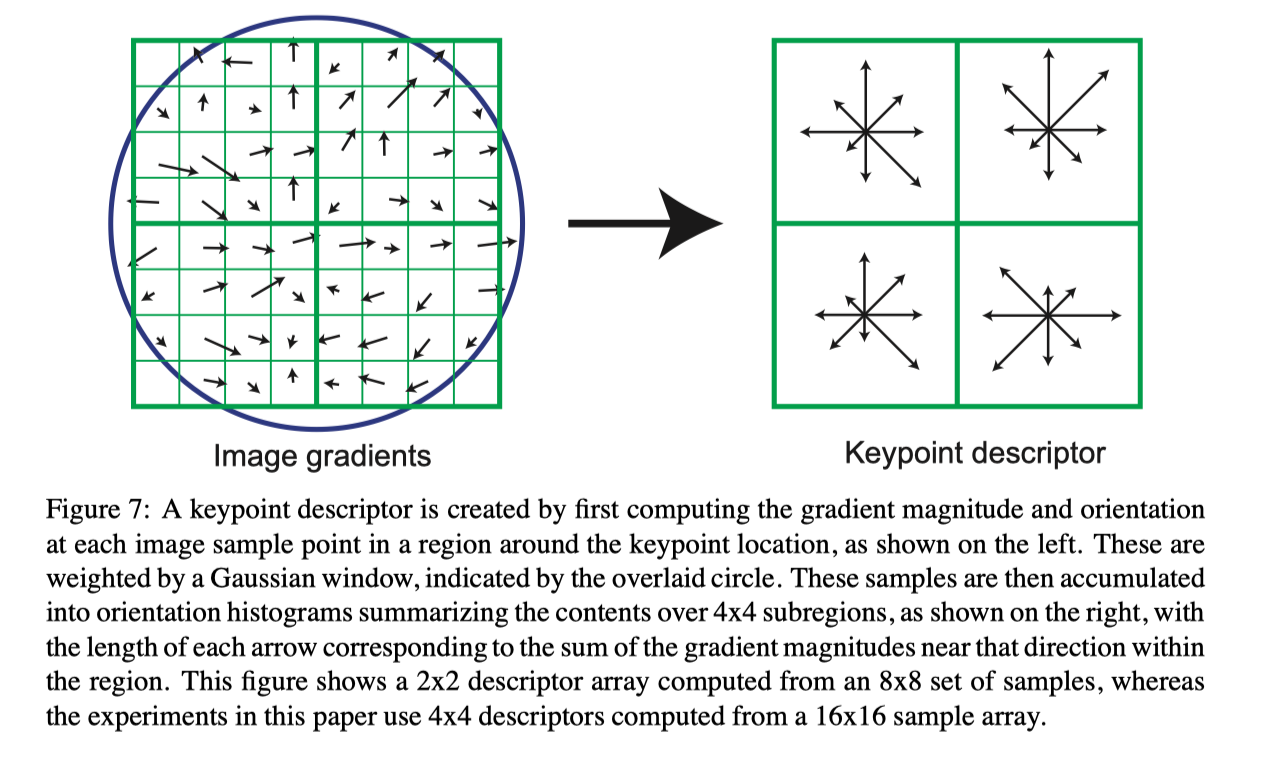

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/kp_desc2.jpg", width =700)

Source: [1]

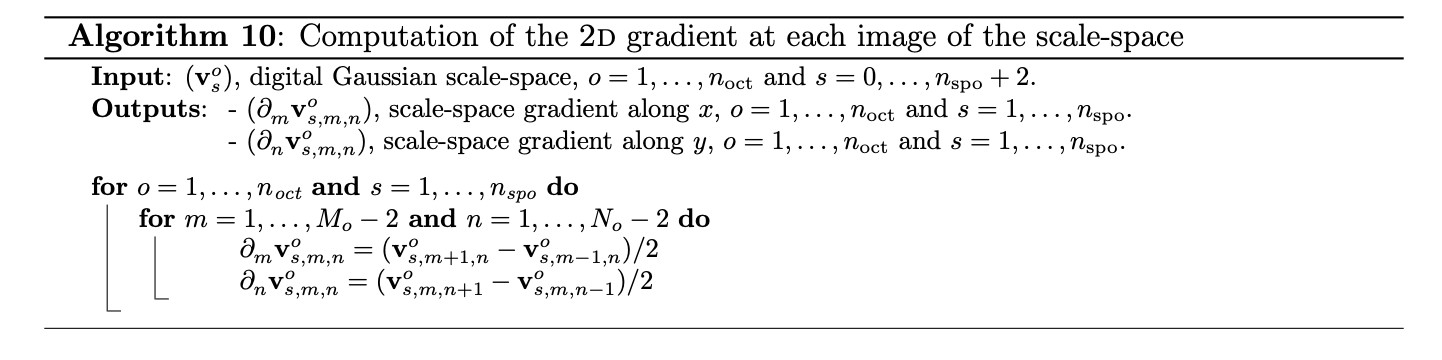

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/algo10.jpg", width =700)

Source: [2]

In [0]:
def compute_gradient_images(v):
    """
    (~Algo 10)
    Input:
    -v: digital gaussian scale space [n_octv ** n_spo] array
        - rows: n_oct octaves 
        - columns: n_spo scales per octave
    
    Output:
    Dvm: Dx(v[o,s]) grad ss wrt x
    Dvn: Dy(v[o,s]) grad ss wrt y 

    
    """
    Dvm=np.empty((v.shape[0],v.shape[1]), dtype=float)
    Dvn=np.empty((v.shape[0], v.shape[1]), dtype=float)
    
    for o in range(v.shape[0]):
        for s in range(v.shape[1]):
            for n in range(v[o,s].shape[0]-2):
                for m in range(v[o,s].shape[1]-2):
                    Dvm[o,s] = ((v[o,s][m+1][n]-v[o,s][m-1][n])/2)
                    Dvn[o,s] = ((v[o,s][m][n+1]-v[o,s][m][n-1])/2)
                                      
    return Dvm, Dvn
                    
                
        

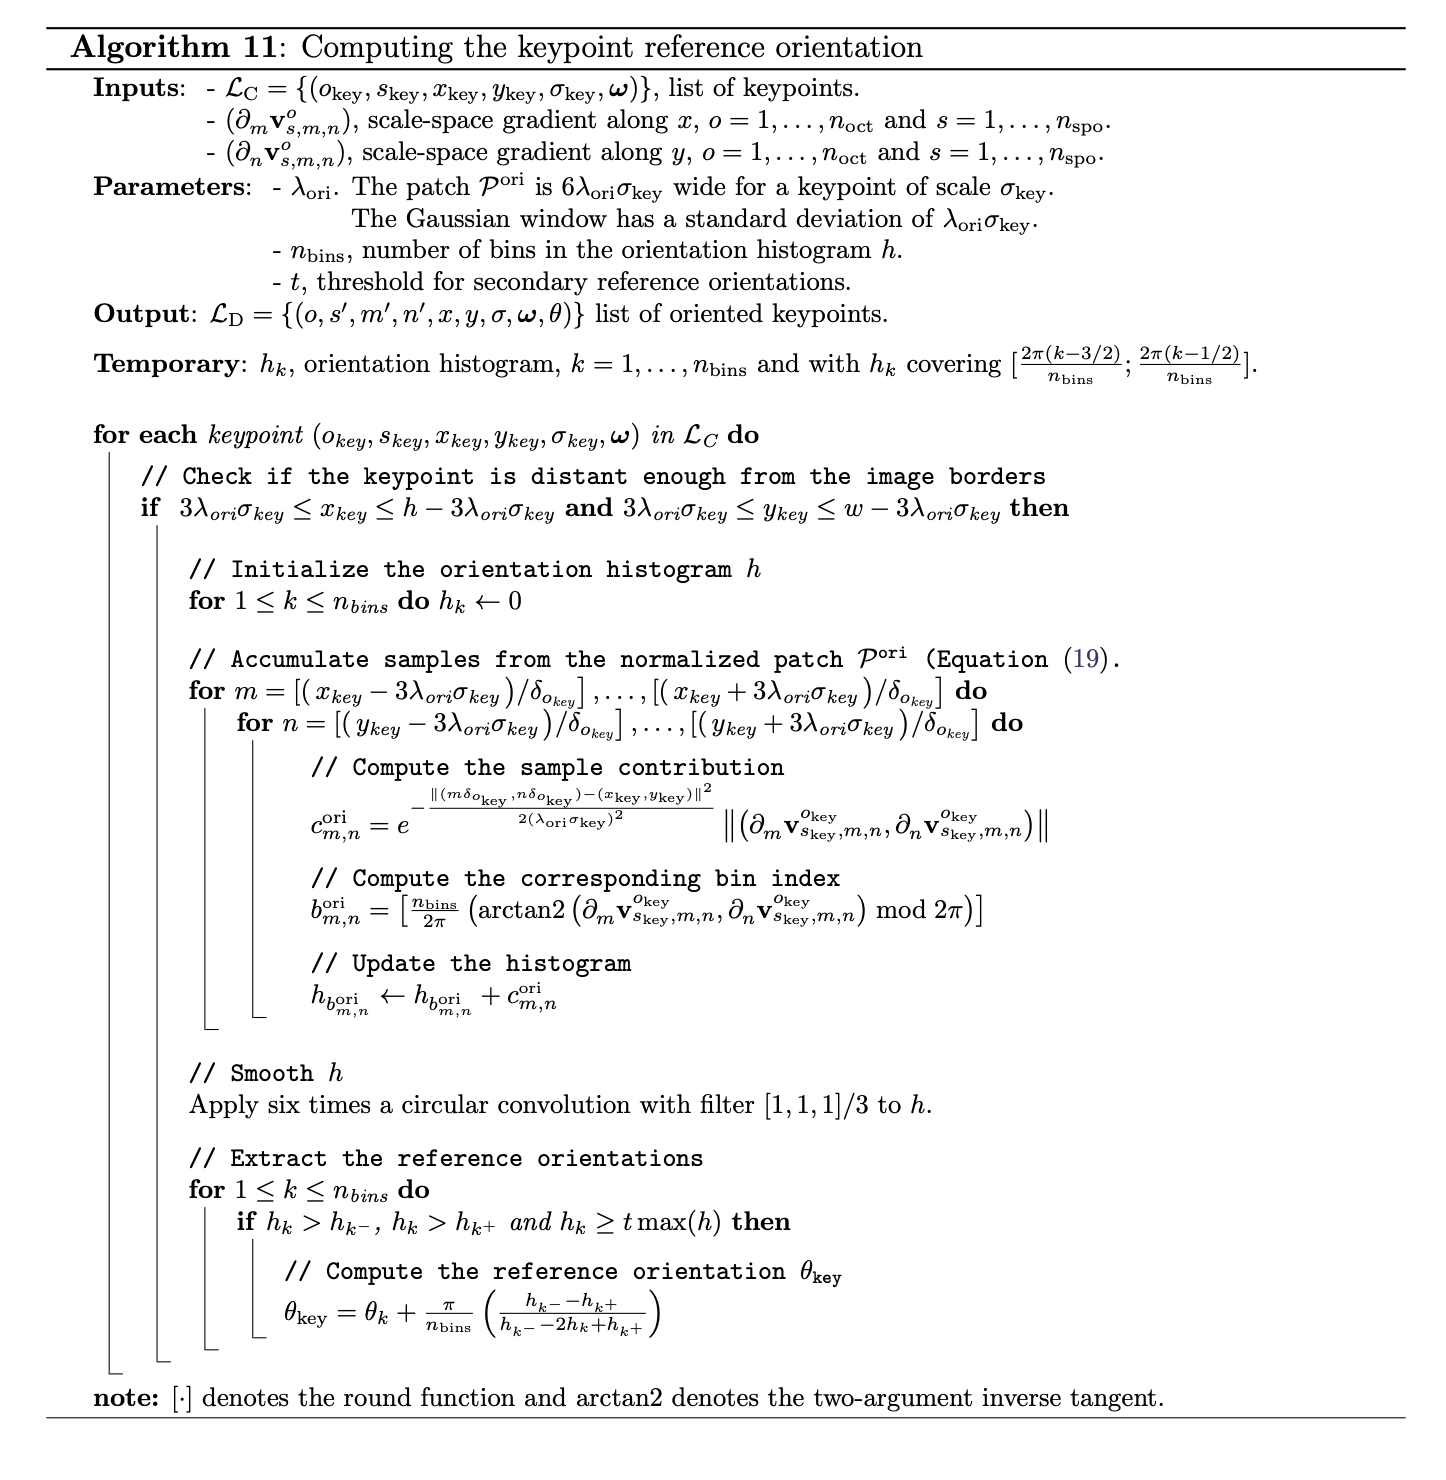

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/algo11.jpg", width =700)

Source: [2]

In [0]:
import math

def compute_keypoint_ori(L_C, Dvm, Dvn):
    #not properly implemented due to time constraints
    """
    (~Algo 11)
    Computes keypoint reference orientation 
    
    Input:
    
    -L_C: list SIFT keypoints tuples [o,s,m,n,sigma,x,y,W]; as output by discard_edge_keypoints()
        :list SIFT keypoints tuples [o_key,s_key,x_key,y_key,sigma_key,W]
    -tuple [Dvm,Dvn]: as output by compute_gradient_images()
                    : Dvm: Dx(v[o,s]) grad ss wrt x
                    : Dvn: Dy(v[o,s]) grad ss wrt y 
  
    
    Output:
    
    -L_D: list ori keypoints
        : [o, s_prime, m_prime, n_prime,x, y,sigma ,W ,theta]
        
    Paramaters:
    
    -n_bins: number of bins in orient hist h
    -lambda_ori: 
               : patch P_ori
                    -width 6*(lambda_ori)*(sigma_key) 
                    -for keypoint of scale: sigma_key

               : guassian window:
                    -std dev: (lambda_ori)*(sigma_key)                
    -t: thresholding secondary ori
    
    Temporary:
    
    -h_k: ori hist
        : k in range(n_bins)
        : covering [2*math.pi*((k-3)/2)/n_bins: 2*math.pi*((k-1)/2)/n_bins]

    
    """

    for i in range(len(L_C)):
        
        #check if keypoint is far enough from image boarders
        [o_key, s_key, m_key, n_key, sigma_key, x_key, y_key, W] = L_C[i]
        
        if 3*(lambda_ori)*(sigma_key) <= x_key <= h - 3*(lambda_ori)*(sigma_key):            
            if 3*(lambda_ori)*(sigma_key)<= y_key <= h - 3*(lambda_ori)*(sigma_key):
                
                #initize orient hist h
                for k in range(1, n_bins+1):
                    h_k = 0
                    
                #accumulate samples from norm path P_ori
                for m in range(np.round(x_key -3*(lambda_ori)*(sigma_key),2), np.round(x_key -3*(lambda_ori)*(sigma_key)),2):
                    for n in range(np.round(y_key -3*(lambda_ori)*(sigma_key),2), np.round(y_key -3*(lambda_ori)*(sigma_key)),2):
                        
                        #compute sample contribution
                        c_ori_mn = np.exp(0) #???
                        
                        #compute corresponding bin idx
                        b_ori_mn = (n_bins/math.pi)*(math.atan2(Dvm[o_key,s_key],Dvm[o_key,s_key])%math.pi)
                        
                        #update hist
                        h_b_ori_mn += c_ori_mn 
                        
                #smooth h
                #apply 6 x circ convol w/ filter range([1,1,1]/3, h)
                
                #extracta ref ori
                for k in range(1, n_bins+1):
                    if h_k_ < h_k < h_k_pl and h_k > tmax(h):
                        
                        #compute reference orientation theta_key
                        theta_key = theta_k + (math.pi/ n_bins)*((h_k_ - h_k_pl)/(h_k_ - 2*h_k + h_k_pl))
        return L_D     
                
        

>## Phase III - Orientation assignment - results

In [0]:
 Dvm, Dvn = compute_gradient_images(DoG_scale_space)
print(Dvm)
print(Dvn)


[[-0.00998194 -0.00029042  0.00272114  0.00277262  0.00209156]
 [-0.00051358  0.00817163  0.00529886  0.00230774  0.00076458]
 [-0.02752716  0.00045622  0.00105894  0.00047991 -0.00021953]
 [ 0.00063102 -0.00162888  0.00056137  0.00223711  0.00192026]]
[[ 0.01748381  0.01430732  0.00630878  0.00273562  0.00119952]
 [ 0.01658525  0.00435392  0.00094067 -0.00023801 -0.00044302]
 [ 0.06016883 -0.00165248 -0.00354608 -0.00419489 -0.00301335]
 [-0.03844371 -0.02517063 -0.00730256 -0.00102973 -0.00057984]]


In [0]:
candidate_extrema_list_f1_ori =compute_keypoint_ori(candidate_extrema_list_f1, Dvm, Dvn)
print(candidate_extrema_list_f1_ori)

ValueError: ignored

# Feature extraction process continued.. 
>## Phase IV - Keypoint descriptor

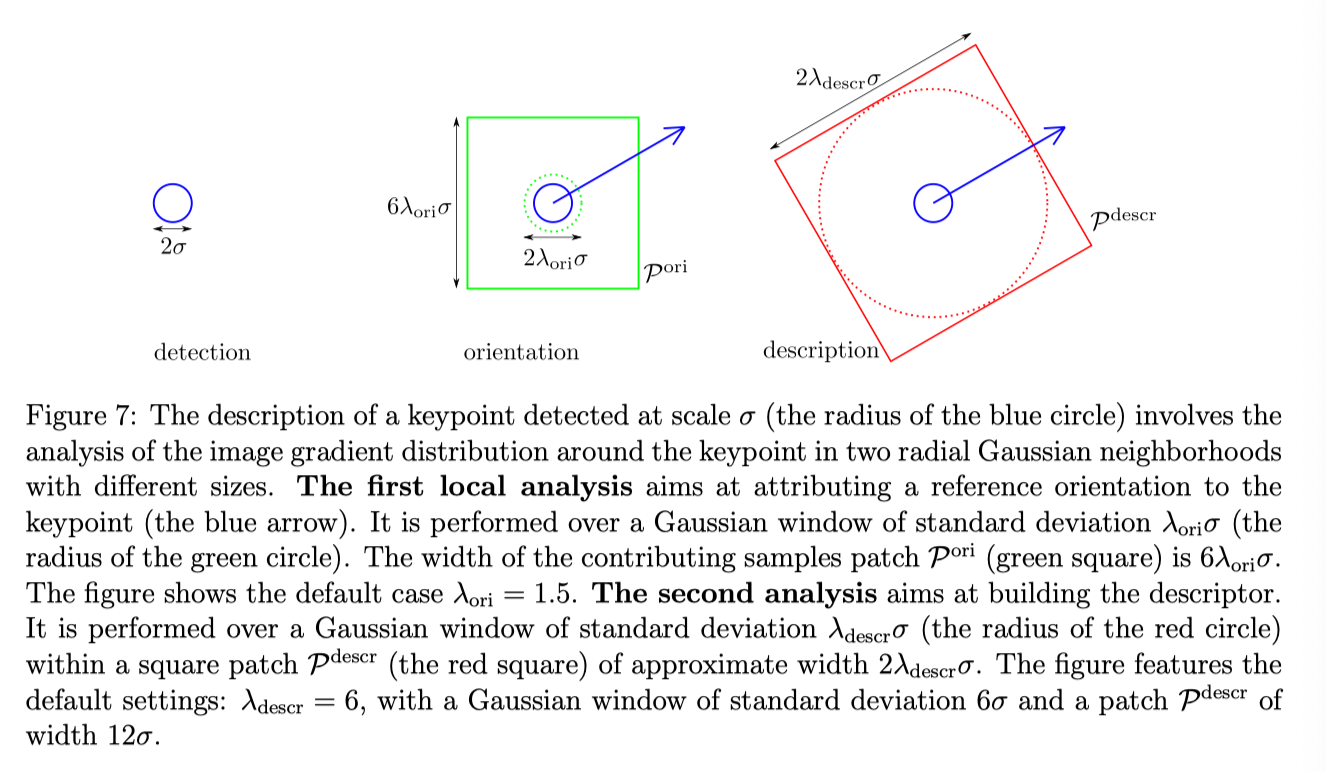

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/kp_desc.jpg", width =700)

Source: [2]

>## Phase IV - Keypoint descriptor -methods

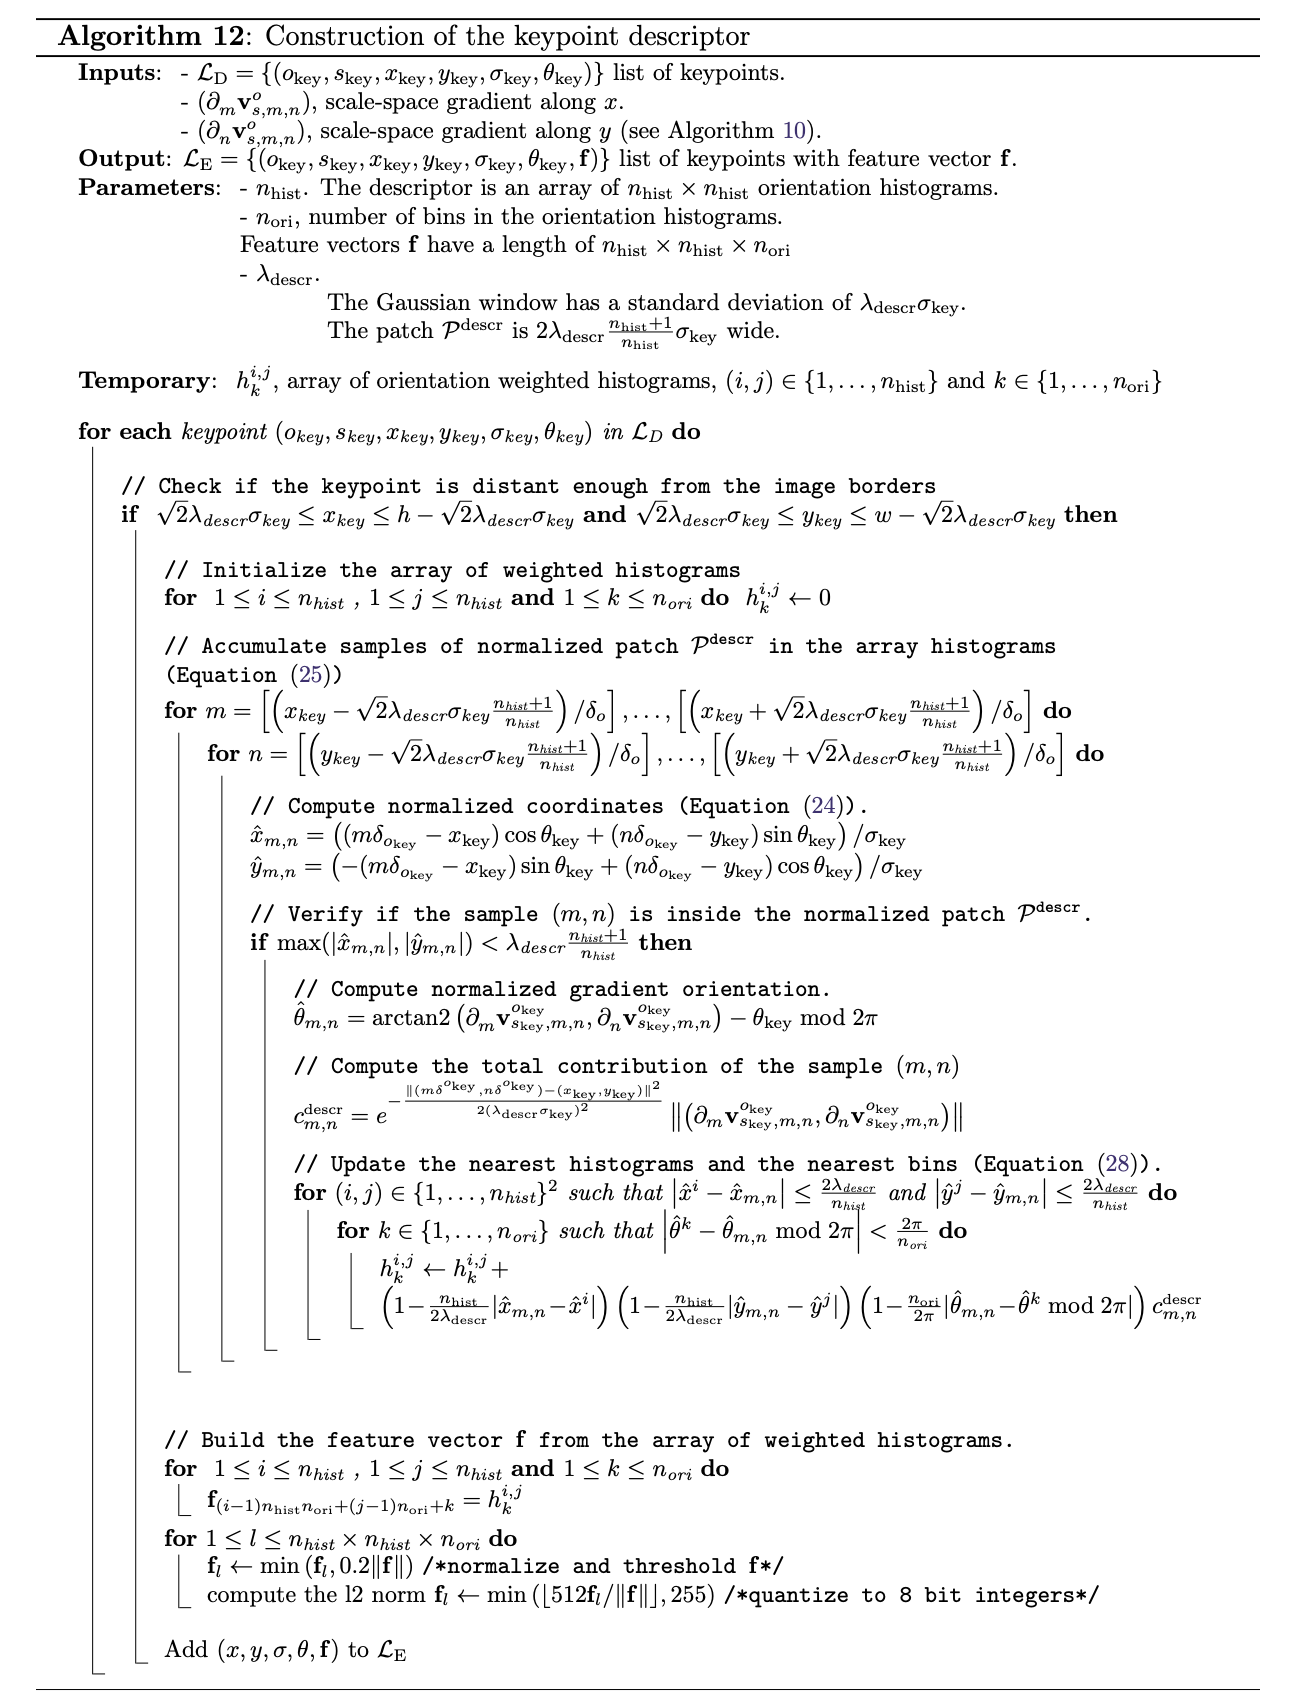

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/algo12.jpg", width =700)

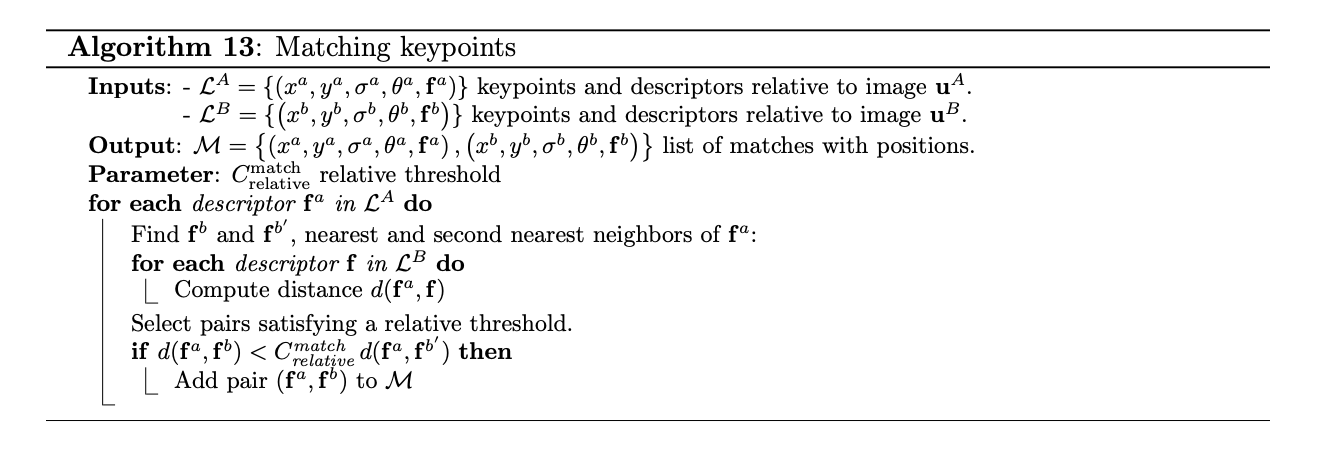

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/algo13.jpg", width =700)

In [0]:
def match_keypoint(L_A, L_A, M, C_mtch_rel):
    #not properly implemented due to time constraints

SyntaxError: unexpected EOF while parsing (<ipython-input-87-7471aea88676>, line 2)

## End.

## Appendix: Default paramaters at various stages


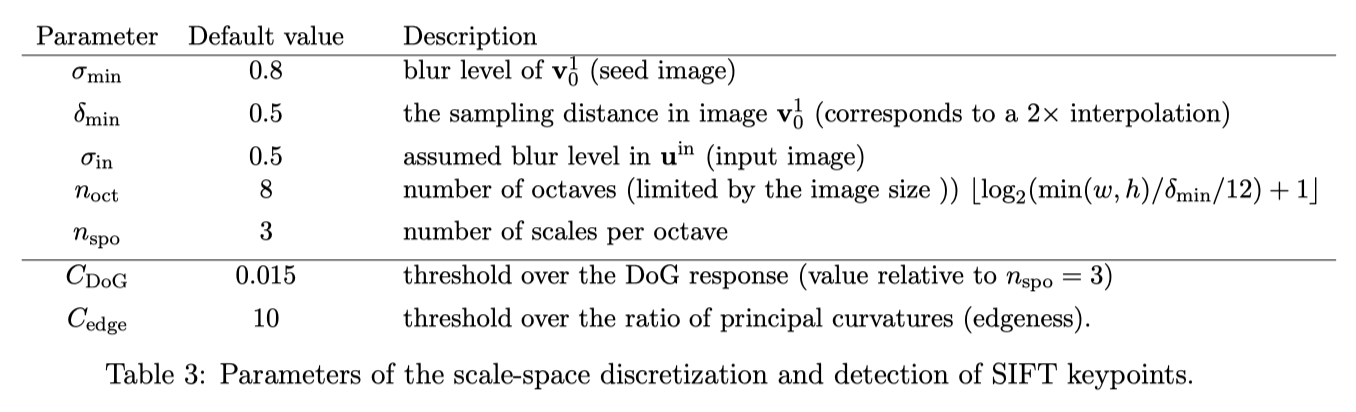

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/param1.jpg", width =700)

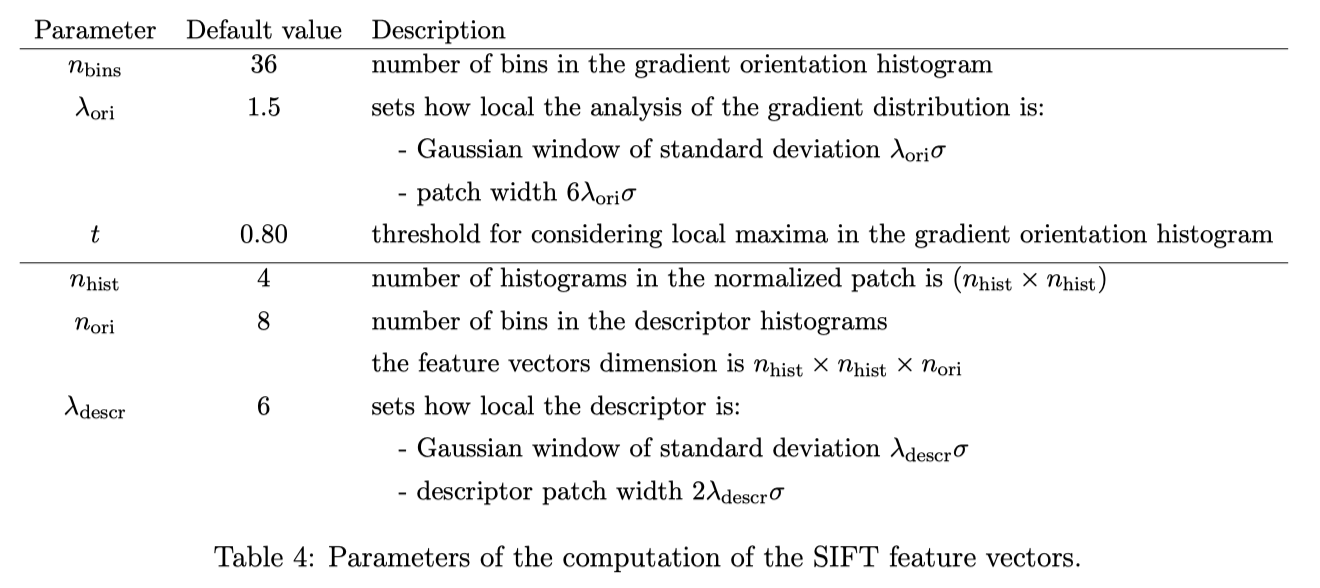

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/param2.jpg", width =700)

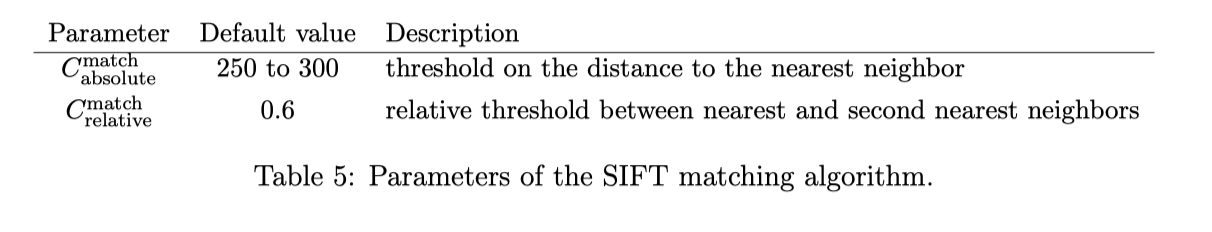

In [0]:
from IPython.display import Image
Image("/content/gdrive/My Drive/cv_sift_implement/notebook_images/param3.jpg", width =700)

## References

[1] D. Lowe, "Distinctive Image Features from Scale-Invariant Keypoints", International Journal of Computer Vision, vol. 60, no. 2, pp. 91-110, 2004. Available: 10.1023/b:visi.0000029664.99615.94.


[2] I. Rey Otero and M. Delbracio, "Anatomy of the SIFT Method", Image Processing On Line, vol. 4, pp. 370-396, 2014. Available: 10.5201/ipol.2014.82.
